# Gaussian processes

Different to [Bayesian Linear Regression](https://github.com/kaibrach/machine-learning/tree/master/bayesian-linear-regression), which was close to the book of Christopher M. Bishop. [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf), this notebook tries to give an introduction to Gaussian processes as descibed in Kevin P. Murphys book [(Machine Learning, A Probabilistic Perspective)](https://doc.lagout.org/science/Artificial%20Intelligence/Machine%20learning/Machine%20Learning_%20A%20Probabilistic%20Perspective%20%5BMurphy%202012-08-24%5D.pdf), because IMHO it is explained a bit more understandable. But thats a matter of taste.

In order to have a cross-reference the sections as well as the variable names are implemented as close as possible to this book.


## Introduction

In `Bayesian Linear Regression` we focused on probability distribution over a finite set of hyperparameters (weight parameters) for function $f$ which results in $p(\theta,D)$. Where $\theta$ represents the finite set of hyperparameters ($\alpha$ and $\beta$) and $D = \{\mathbf{X},\mathbf{y}\}$ represents the observed data.

We tried to infer optimal weight parameters for $\theta$ by [maximizing the likelihood function](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation). [Maximizing the a posteriori](https://de.wikipedia.org/wiki/Maximum-a-posteriori-Sch%C3%A4tzung) for estimating optimal values would also be possible. An alternative to computing a point estimate of the hyperparameters is to compute their posterior distribution. 

Models with a finite set of hyperparameters is so called **parametric model**. In general this means that the  complexity  of  the  model  is  bounded  even  if  the  amount  of  data  is unbounded which makes them not very flexible. With increasing complexity of the data a model with higher number of parameters is needed to explain the data reasonably well.

Besides the static finite parametric model there is also a model called **non-parametric model**. Non-parametric  models assume that the data distribution cannot be defined in terms of such a finite set of parameters. But they can often be  defined by assuming an infinite dimensional $\theta$.  Usually, in this case, we think of $\theta$ as a function.
The amount of information that $\theta$ can capture about the data $D$ can grow as the amount of data grows. This makes non-parametric models more flexible because the number of parameters depend on the dataset size and they can be seen as having infinitely many parameters.


## Examples of (non-)parametric models

![http://mlss.tuebingen.mpg.de/2015/slides/ghahramani/gp-neural-nets15.pdf](img/overview_parametric_nonparamentric.PNG)


In this notebook we will concentrate on performing Bayesian inference over functions. Therefore we will use **Gaussian Processes (GPs)** as non-parametric model. GPs defines a prior over function, which can be converted into a posterior over function if we have observed some data. GPs can be used for `regression` as well as `classification` tasks.

For the sake of simplicity in this notebook we will set the focus on regression task only and try to implement the mathematics as close as possible from scratch only using `NumPy`.



## Gaussian processes for regression

**Definition:** A GP is a [stochastic process](https://en.wikipedia.org/wiki/Stochastic_process) where each finite subset of random variables is multidimensional normally distributed (multivariate Gaussian). 

Consider the problem of **non-linear regression**. You want to learn the function $f$ with [error bars](https://en.wikipedia.org/wiki/Error_bar) from data $D = \{\mathbf{X},\mathbf{y}\}$ . Error bars often represent one standard deviation of uncertainty, one standard error, or a particular confidence interval (e.g., a 95% interval).

![http://mlss.tuebingen.mpg.de/2015/slides/ghahramani/gp-neural-nets15.pdf](img/gp_example.PNG)

The dots indicate the training data $D = \{\mathbf{X},\mathbf{y}\}$, the red lines indicates the error bars, and the blue line shows the learned function $f$.

As we already figured out, a GP defines a distribution over functions which can be used for doing Bayesian inference over these functions as we did for parametric model.


**Parametric (weight space) view:**
 
 $$
  P(\theta \mid D) = \frac{P(D \mid \theta) \, P(\theta)}{P(D)}
 $$
 
 **Non-parametric (function space) view:**
 
 $$
  P(f \mid D) = \frac{P(D \mid f) \, P(f)}{P(D)}
 $$
 
 
 **Note:** $f$ is a random variable


It seems that this might be difficult, but it turns out that we only need to be able to define a distribution over the values of the functions at a finite but random number of points 
$\mathbf{x}_1 \dots \mathbf{x}_N \subset \mathbf{X}$ where the joint marginal distribution over these variables $p(f(\mathbf{x}_1),...,f(\mathbf{x}_N))$ is also a multivariate Gaussian. Now we can say that a Gaussian process defines a distribution over functions $p(f)$ instead of distribution over parameters $p(\theta)$.

A GP is completely specified by its mean function $m(\mathbf{x})$ and covariance function $\kappa(\mathbf{x},\mathbf{x'})$ of the real process $f(\mathbf{x})$

$$
 \begin{align*}
m(\mathbf{x}) &= \mathbb{E}[ f(\mathbf{x})] \\
\kappa(\mathbf{x},\mathbf{x'}) &= \mathbb{E}[(f(\mathbf{x}) - m(\mathbf{x}))(f(\mathbf{x'}) - m(\mathbf{x'})^T)]
 \end{align*}
 \tag{1}
$$

and will write the entire GP as

$$
f(\mathbf{x}) \sim GP(m(\mathbf{x}),\kappa(\mathbf{x},\mathbf{x'})) \tag{2}
$$

The joint Gaussian for any finite set of points (as mentioned above) can now be written as

$$p(\mathbf{f} \lvert \mathbf{X}) = \mathcal{N}(\mathbf{f} \lvert \boldsymbol\mu, \mathbf{K})\tag{3}$$

where $\mathbf{f} = (f(\mathbf{x}_1),...,f(\mathbf{x}_N))$, $\boldsymbol\mu = (m(\mathbf{x}_1),...,m(\mathbf{x}_N))$ and $\mathbf{K}_{ij} = \kappa(\mathbf{x}_i,\mathbf{x}_j)$. It is common to use a mean function $m(\mathbf{x}) = 0$, since the GP is flexible enough to model the mean arbitrarily well. It is required that $\kappa$ is a positive definite kernel or covariance function. This requirement leads to the fact that the shape of the GP (ellipsoid) is defined by `Covariance Matrix` or `Kernel` $\mathbf{K}$ and gives us information about similarity of datapoints $\mathbf{x}_i$ and $\mathbf{x}_j$. 
(For detailed explaination about kernels see Section 14.2 in [1]).

![Machine Learning, A Probabilistic Perspective](img/gp_two_training_points.PNG)

More precisely if points $\mathbf{x}_1$ and $\mathbf{x}_2$ are deemed by the kernel to be similar, then we expect the output of the function at those points, $f(\mathbf{x}_i)$ and $f(\mathbf{x}_j)$, to be similar too. 

## Mulivariate Gaussian Theorem

Before starting with real regression tasks and predicting data, we have to clarify how to inference in jointly Gaussian distributions. Therefore we will get in touch with the most important theorem when working with Multivariate Gaussian.

$\tag{4}$
![Machine Learning, A Probabilistic Perspective](img/mvn_theorem.PNG) 

This theorem is of such crucial importance and you should keep it in mind when working with Multivariat Normal Distributions.

We see that both the `marginal` and `conditional` distributions are themselves Gaussian. 

For the `marginals`, we just extract the rows and columns corresponding to $x_1$ or $x_2$. 
For the `conditional`,we have to do a bit more work. However, it is not that complicated: the conditional mean is
just a linear function of $x_2$, and the conditional covariance is just a constant matrix that is independent of $x_2$. 

The theorem shows three different (but equivalent) expressions for the posterior mean $\mu$,
and two different (but equivalent) expressions for the posterior covariance $\Sigma$; each one is useful in
different circumstances.

We will use this theorem in the next sections in this notebook. If you want to read more about it, see Section 4.3.1 in [1]

## Predictions using noise-free observations

If we want to use the GP to predict $f(\mathbf{x})$ for a training value $x$ that has been already seen, for sure we want that the GP returns $f(\mathbf{x})$ without any uncertainty. This will only occur if the observations are noiseless and therefore predicting new data points within the range of a discrete training data points is known as **interpolation**.
This means in this case the GP acts as interpolator.

Now we want to do some predictions. Suppose we observe a training set $D = \{(x_i, f_i), i = 1:N\}$, where $f_i = f(x_i)$ is the noise-free observation of the function $f$ evaluated at point $x_i$.
Based on a given test set $\mathbf{X}_*$ of size $N_* \times D$ we want to predict the function output $f(\mathbf{x}_*)$.

As we know from equation (3) the prior of a Gaussian process is a joint distribution over functions. So the **joint distribution** of the training outputs $\mathbf{f}$, and the test outputs $\mathbf{f}_*$ is


$$
\begin{pmatrix}\mathbf{f} \\ \mathbf{f}_*\end{pmatrix} \sim \mathcal{N}
\left(
\begin{pmatrix}\mathbf{\mu} \\ \mathbf{\mu}_*\end{pmatrix},
\begin{pmatrix}\mathbf{K} & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}
\right)\tag{5}
$$

where $\mathbf{K} = \kappa(\mathbf{X},\mathbf{X})$ is $N \times N$, $\mathbf{K}_* = \kappa(\mathbf{X},\mathbf{X}_*)$ is $N \times N_*$ and $\mathbf{K}_{**} = \kappa(\mathbf{X}_*,\mathbf{X}_*)$ is $N_* \times N_*$ with $N$ training data and $N_*$ new input data (test data). 

Now, because we are interested in the **conditional distribution**, we have to do inference of the joint distribution using the **Multivariate Gaussian Theorem** for infering posterior mean $\mu_*$ and covariance $\Sigma_*$
$$
\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y})&= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)\tag{6} \\
\boldsymbol{\mu_*} &= \mu(\mathbf{X}_*) + \mathbf{K}_*^T \mathbf{K}_*^{-1} \mathbf{(f - \mu(X))} \tag{7} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_*^{-1} \mathbf{K}_*  \tag{8}
\end{align*}
$$



## Predictions using noisy observations

Now, lets consider the more realistic part when we do not have access to the function values directly but to a noisy version of them

$$
y = f(x) + \epsilon , \\ 
\epsilon \sim \mathcal{N}(0, \sigma_y^2) \tag{9}
$$

In this case the model only have to get closer to the observed data and there is no need to interpolate them.
The covariance for the observed noisy data will changes as follows

$$
\mathbf{K}_y = \kappa(\mathbf{X},\mathbf{X}) + \sigma_y^2\mathbf{I_N} = \mathbf{K} + \sigma_y^2\mathbf{I_N} \tag{10}
$$

where $\sigma_y^2$ represents the noise term that is i.i.d (independent and identically distributed) to the diagonal of matrix $\mathbf{K}_y$ and $\mathbf{I_N}$ denotes the $N \times N$ unity matrix.


With the noise term presented in equation $(9)$ and the resulting covariance shown in equation $(10)$ we can write the joint distribution of the observed target values $\mathbf{f_*}$ and the function values $\mathbf{y}$ at the test locations under the prior as 

$$
\begin{pmatrix}\mathbf{y} \\ \mathbf{f}_*\end{pmatrix} \sim \mathcal{N}
\left(\boldsymbol{0},
\begin{pmatrix}\mathbf{K}_y & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}
\right)\tag{11}
$$

and for notational simplicity a mean of zero is assumend. 

Now, we can convert the GP prior from equation $(3)$ into GP posterior $p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})$ after having observed some data $\mathbf{y}$. The posterior can then be used to make predictions $\mathbf{f}_*$ given new input $\mathbf{X}_*$. Again we are using the **Multivariate Gaussian Theorem** for infering posterior mean $\mu_*$ and covariance $\Sigma_*$ from **joint distribution** in equation $(11)$ to get the **conditional distribution**

$$
\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y}) 
&= \int{p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{f})p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})}\ d\mathbf{f} \\ 
&= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)\tag{12} \\
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}_*^{-1} \mathbf{y}\tag{13} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_*^{-1} \mathbf{K}_*\tag{14} \\
\end{align*}
$$

**Note:** We have to keep in mind that $\sigma_y^2$ represents the noise term in the diagonal of $\mathbf{K_y}$. 
So if we expect noise-free training data this value is set to zero and nonzero if the training observations are noisy.


**Additional Information:** In the case of a single testinput the equation can be written as follows:

$$
p(f_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y}) = \mathcal{N}(f_* \lvert \mathbf{k}_*^t\mathbf{K_y^{-1}}\mathbf{y},k_{**}-\mathbf{k^T}\mathbf{K_y^{-1}}\mathbf{k_*})\tag{15}
$$

where $\mathbf{k_*} = [k(x_*,x_1), \dots , k(x_*,x_N)]$ and $k_{**} = k(x_*,x_*)$.

Another way to write the posterior mean $\mathbf{\mu_*}$ is as follows:
$$
\overline{f_*} =  \mathbf{k}_*^t\mathbf{K_y^{-1}}\mathbf{y} = \sum_{i=1}^N \alpha_i k(x_i,x_*)
$$

where $\alpha = \mathbf{K_y^{-1}}\mathbf{y}$


## RBF Kernel Function

We already talked about noise-free and noisy observations but what about the kernel function we used in the equations above.
In this notebook we will use the **squared exponential kernel**, also known as **Gaussian kernel** or **RBF (Radial basis function) kernel**, but feel free to add additional kernels too.

The kernel or squared exponential covariance function in 1D is defined as follows:


$$
\begin{align*}
\kappa(\mathbf{x}_i,\mathbf{x}_j)
&= \sigma_f^2 \exp(-\frac{1}{2l^2}
(\mathbf{x}_i - \mathbf{x}_j)^2)\\
&= \sigma_f^2 \exp(-\frac{1}{2l^2}
(\mathbf{x}_i - \mathbf{x}_j)^T(\mathbf{x}_i - \mathbf{x}_j))\\
&= \sigma_f^2 \exp(-\frac{1}{2l^2}
(\mathbf{x}_i^T\mathbf{x}_i + \mathbf{x}_j^T\mathbf{x}_j - 2\mathbf{x}_i^T\mathbf{x}_j)\\ \tag{16}\label{eq16}
\end{align*}
$$

**Note**: Just for the sake of information I mentioned here that the additive noise is only added to $\kappa_y$:

$$
\begin{align*}
\kappa_y(\mathbf{x}_i,\mathbf{x}_j)
&= \sigma_f^2 \exp(-\frac{1}{2l^2}
(\mathbf{x}_i - \mathbf{x}_j)^2)
+\sigma_{y}^2 \delta_{ij} \\ \tag{17} 
\end{align*}
$$



where $\sigma_f >0$ is the signal variance, $l > 0$ is the lengthscale and $\sigma_y^2 \geq 0$ is the noise covariance. The noise variance is applied only when $i=j$

* **Lengthscale $l$** describes how smooth a function is. Small lengthscale value means that function values can change quickly, large values characterize functions that change only slowly. Lengthscale also determines how far we can reliably extrapolate from the training data.

* **Signal variance $\sigma_f$** is a scaling factor. It determines variation of function values from their mean. Small value of $\sigma_f^2$ characterize functions that stay close to their mean value, larger values allow more variation. If the signal variance is too large, the modelled function will be free to chase outliers.

* **Noise variance $\sigma_y^2$** is formally not a part of the covariance function itself. It is used by the Gaussian process model to allow for noise present in training data. This parameter specifies how much noise is expected to be present in the data.

## Computational and numerical issues

For reasons of numerical stability, it is unwise to directly invert $\mathbf{K}_y$. A more robust alternative is to compute a [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) $\mathbf{K_y} = \mathbf{L}\mathbf{L^T}$ (see also Algorithm 15.1 in <sup>[1]</sup>)
For the reason of simplicity I will write down the algorithms as explained in the slides for Gaussian Processes of [Nando de Freitas - Gaussian Processes](https://www.cs.ubc.ca/~nando/540-2013/lectures/l6.pdf)
$$
\begin{align*}
\mathbf{L} &= cholesky(\mathbf{K} + \sigma_y^2\mathbf{I}) \\
\mathbf{Lk} &= L \setminus K_* \\
\mathbf{\alpha} &= L^T \setminus (L \setminus y) \\
\mathbf{\mu_*} &= \mathbf{Lk}^T\alpha \\
\mathbf{\Sigma_*} &= K_{**}-\mathbf{Lk}^T\mathbf{Lk}\\
\end{align*} \tag{18}
$$

`\` = solve a linear matrix equation, or system of linear scalar equations. This can be achived by numpy function `np.linalg.solve(...)`

## From Linear Regression to GP Classification

The following picture shall give an overview how we can get from one parametric model to another using either **kernel functions**, **Bayesian inference** or **classification**

![http://mlss.tuebingen.mpg.de/2015/slides/ghahramani/gp-neural-nets15.pdf](img/gp_overview.PNG)


Ok, so far so good. This is the minimum we need to know for implementing GPs and applying them to regression problems. For further details, please consult the literature in the [References](#References) section. Besides this books, there are many more explanations that can be found in the internet. Here are some good sources for GPs:

* [Nando de Freitas](https://www.cs.ubc.ca/~nando/540-2013/lectures/l6.pdf)
* [Nando de Freitas (video)](https://www.youtube.com/watch?v=4vGiHC35j9s)
* [Katherine Bailey](http://katbailey.github.io/post/gaussian-processes-for-dummies/)
* [Tomi Peltola (Demo)](http://www.tmpl.fi/gp/)
* [Uni Konstanz (Demo)](https://www.jgoertler.com/visual-exploration-gaussian-processes/)

In the next section we are starting to implement GPs with plain `NumPy` from scratch.


# Implementation

Enought theory, now we want to implement the maths we described above using NumPy. Because we want to plot our results we first will define some plotting functions.

## Plot Functions

Because we work with multivariate Gaussian we want to plot the results in 1D as well as 2D, therefore we define some plot functions. You will see the results later in this notebook.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_1D_gp(mu, cov, X_test,y_test=None, X_train=None, Y_train=None, f=[],title=None):
    '''
    Plotting the GP in 1D
    Args:
        mu:      Mean (m x 1)
        cov:     Covariance  (m x n)
        X_test:  Test Data (m x d)
        X_train: Training Data (m x d)
        Y_train: Training targets (m x 1)
        samples: Samples from Prior/Posterior(m x d)
        title:   Title of the plot
    '''
    
    X_test = X_test.ravel()
    mu = mu.ravel()
    
    # https://en.wikipedia.org/wiki/1.96
    uncertainty = 1.96 * np.sqrt(np.diag(cov))

    ax = plt.gca()
    
    # plot the test points
    ax.plot(X_test, mu, label='$\mu_*$')
    
    # plot the truth
    if y_test is not None:
        ax.plot(X_test, y_test, label='$y_{truth}$')
    
    # plot the functions
    for i, f in enumerate(f):
        ax.plot(X_test, f, lw=1, ls='--', label=f'$f_{i+1}(x)$')
        
    # plot the training points
    if X_train is not None:
        ax.plot(X_train, Y_train, 'rx',label='$X_{Train}$')
    
    col=ax.lines[-1].get_color()
    # plot uncertainty
    ax.fill_between(X_test, mu + uncertainty, mu - uncertainty, alpha=0.1,label='$2\sigma$ Uncertainty')
    #plt.errorbar(X_test, mu, yerr=uncertainty, capsize=0, alpha=0.1, color=col);
    
        
    # plot the title
    if title is not None:
        ax.set_title(title)  
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
        
    ax.legend()

    
def plot_2D_gp(gx, gy, mu, X_train_2D, Y_train_2D, title, subplt):
    '''
    Plotting the GP in 2D
    
    Args:
        gx:     Meshgrid x-coordinate matrices from coordinate vectors.
        gy:     Meshgrid y-coordinate matrices from coordinate vectors.
        https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html
        mu:     Mean (m x 1)
        X_train: Training Data (m x d)
        Y_train: Training targets (m x 1)
        title:   Title of the plot
        subplt:   Number of the subplot
    '''
    
    # get the current figure
    fig = plt.gcf()
    # need 3d projection for each subplot, otherwise we run in trouble
    
    ax = fig.add_subplot(1, 3, subplt, projection='3d')
    
    # plot the surface as well as the contour
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.rainbow, linewidth=0, 
                        alpha=0.5, antialiased=False,rstride=3, cstride=3)
    ax.contourf(gx, gy, mu.reshape(gx.shape), zdir='z', offset=-2.5, cmap=cm.coolwarm)

    if X_train_2D is not None and Y_train_2D is not None:
        ax.scatter(X_train_2D[:,0], X_train_2D[:,1], Y_train_2D,
                   marker='x', 
                   c=Y_train_2D, 
                   cmap=cm.viridis,
                   label='$X_{Train}$')
        ax.legend(loc='lower right')
        
    
    # set the axis and some limits
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_zlim(-2.5,2)
    #ax.set_zticks(np.linspace(0,0.2,5))
    ax.view_init(27, -21)
    ax.set_title(title)

## Kernel Function

In this notebook we will use the `Radial-basis function kernel RBF (aka squared-exponential kernel)`, specified in equation $(16)$, to create our covariance matrix. The default hyperparameters $l=1$, $\sigma_f=1$ of the kernel function represent the values decribed in [1]. For executing an individual Kernel function the below implemented Callback-function could be used.

In [2]:
''' 
Callback function to use different Kernels with individual parameters

Args:
    kernel: Kernel function
    XI: Array of m points (m x d)
    XJ: Array of n points (n x d)
    **params: keyworded parameter related to the kernel
'''

def Kernel(kernel,XI,XJ,**params):
    return kernel(XI,XJ,**params)

# Lambda function is damn slow :-(
#Kernel = lambda kernel, XI, XJ, *params: \
#    np.array([[kernel(xi, xj, *params) for xj in XJ] for xi in XI])

In [3]:
def rbf_kernel(Xi, Xj,l=1.0, sigma_f=1.0):
    '''
    Computes a covariance between the points xi and xj using the RBF Kernel.

    Args:
        Xi:      Vector of datapoints point (m x d)
        Xj:      Vector of datapoints point (n x d)
        l:       Lengthscale
        sigma_f: Signal variance

    Returns:
        Covariance matrix between datapoints in Xi and Xj.
    '''
    
#     Xi=Xi.reshape(-1,1)
#     Xj=Xj.reshape(-1,1)
    
    #return sigma_f**2 * np.exp(-0.5 / l**2 *np.sum((xi - xj)**2) ) # for lambda
    sqdist = np.sum(Xi**2, 1).reshape(-1, 1) + np.sum(Xj**2, 1) - 2 * np.dot(Xi, Xj.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

As we already know, the main usage of a kernel is to compute the GP’s covariance between datapoints. Based on these datapoints different kernels could be used to measure similarity. Description of the individual Kernel functions can be found in [References](#References) as well as in the [The Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/). Another overview and description about the individual kernels can be found in scikit-learn documentation [GP-Kernels](http://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels).

## Datasets

Due to the fact that the implementation is based on `NumPy` arrays the example dataset are based on $N$ scalar observations $x_{i = 1,\ldots,N}$ which are combined into a $N \times 1$ matrix $\mathbf{X}$

Training observations $\mathbf{X_{train}}$ are generated from $\mathbf{X}$ with function $g(x)$ which also generate random noise whose variance can be specified with the `noise_variance` parameter. In this example $g(x)$ will be used for generating noisy samples from a sinusoidal function. Please feel free to adapt function $g(x)$ or add additional ones.

In [4]:
# Sinusoidal function for creating training observations
def g(X, noise_variance):
    '''Non-Linear Sinus function plus noise'''
    return np.sin(X) + epsilon(X.shape, noise_variance)

# Function for creating random noise
def epsilon(size, noise_variance):
    '''Random normal distributed noise with zero mean'''

    return noise_variance * np.random.randn(*size)

## Prior

First we want to sample three **noise-free** functions from a `GP prior` with zero mean, as described in equation $(3)$, using our RBF kernel. The covariance matrix will be computed with the default kernel hyperparameters $l=1$, $\sigma_f=1$. For obtaining the samples from the GP prior we have to sample from the corresponding multivariate normal distribution.


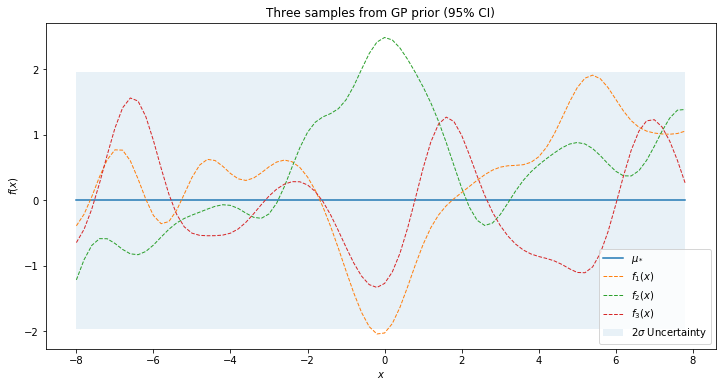

In [5]:
# Finite number of test points (These points are used in the upcoming cells as well)
X = np.arange(-8, 8, 0.2).reshape(-1, 1)

# Number of random functions (samples) drawn from the prior
NF = 3

# Mean and covariance of the prior using RBF Kernel
mu = np.zeros(X.shape)
K = Kernel(rbf_kernel,X,X)

# Draw three samples from the prior
f_prior = np.random.multivariate_normal(mu.ravel(), K, NF)

# Plot mean, prior samples and 95% CI
plt.figure(figsize=(12, 6))
plot_1D_gp(mu, K, X_test=X, f=f_prior, title='Three samples from GP prior (95% CI)')

The figure above shows the three **noise-free** random functions from the GP prior with mean of zero as well the $2\sigma$ (95%) confidence interval (uncertainty) obtained from diagonal of the covariance matrix.

## Posterior Predictive

Next we are using the standard rules for conditioning to calculate the posterior predictive distribution from the joint distribution for obtaining $\boldsymbol{\mu_*}$ and $\boldsymbol{\Sigma_*} $.

Therefore we are calculating the covariance matrix as defined in equation $(11)$ using our kernel function for the different datapoints.
**Hint:** Try to implement different kernel function and check the results.

Based on the calculated covariance matrix the posterior predictive distribution is calculated using equations $(12)$ and $(13)$

**Note:** We have to keep in mind that $\sigma_y^2$ represents the noise term in the diagonal of $\mathbf{K_y}$. 
So if we expect noise-free training data this value is set to zero and nonzero if the training observations are noisy.


In [6]:
from numpy.linalg import inv
from numpy.linalg import cholesky
from numpy.linalg import solve

def posterior_predictive(X_s, X_train, Y_train,sigma_y=1e-8, use_cholesky=True, Kf=rbf_kernel,**Kp):
    '''
    Computes the GP posterior predictive distribution from training data X_train and Y_train 
    and n new inputs X_s.
    
    Args:
        X_s: New input data (n x d)
        X_train: Training data (m x d)
        Y_train: Training targets (m x 1)
        sigma_y: Noise parameter
        use_cholesky: Numerical computation with cholesky(testphase)
        Kf: Kernel function
        Kp: Individual Kernel parameters
    
    Returns:
        Posterior mean (mu_s) (n x d) and covariance matrix (sigma_s)(n x n)
    '''

    # Add additive noise to K for noisy observations
    K_y = Kernel(Kf,X_train,X_train,**Kp) + sigma_y**2 * np.eye(len(X_train)) 
    K_s = Kernel(Kf,X_train,X_s,**Kp)  
    K_ss = Kernel(Kf,X_s,X_s,**Kp) + 1e-8 * np.eye(len(X_s)) # Add small value otherwise invalid value encountered in sqrt
    K_inv = inv(K_y)
    
    # Use cholesky decomposition
    if use_cholesky == True:
        L = cholesky(K_y)
        Lk = solve(L, K_s)
        a = solve(L, Y_train)
        mu_s = Lk.T.dot(a)      
        sigma_s = K_ss - Lk.T.dot(Lk)
    else:
        # Equation (12)
        mu_s = K_s.T.dot(K_inv).dot(Y_train)
        # Equation (13)
        sigma_s = K_ss - K_s.T.dot(K_inv).dot(K_s)       

    return mu_s, sigma_s

## Prediction from noise-free training data


In the follwowing example we want to create three random functions drawn from our GP `posterior_predictive` function that are conditioned on five noise-free training observations `X_train` and `Y_train`. We can either create random noise-free observation values `RV=True` or static values `RV=False`

As mentioned in the introduction, if the observations are noiseless (noise-free model), variance at the training observation is zero, the GP acts as interpolator, which means that all random functions going through the training points.

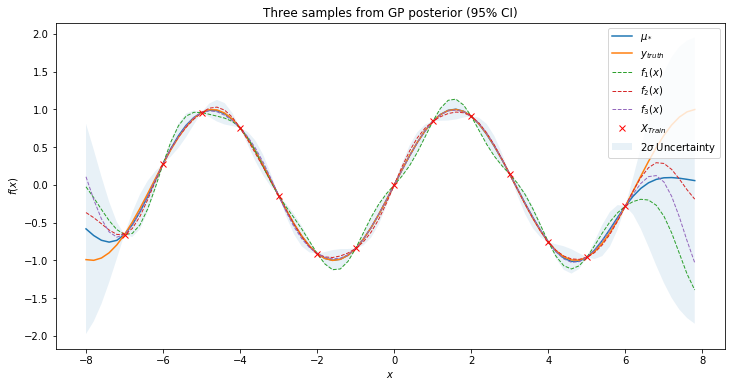

In [7]:
# Switch for random values
RV=False

# Number of training observations
N = 5

# Number of random functions (samples) drawn from the posterior
NF = 3

# Noise free training data either random or static
if RV==False:
    X_train = np.arange(np.min(X)+1, np.max(X)-1, 1).reshape(-1, 1)
    #X_train = np.linspace(np.min(X),np.max(X),N).reshape(-1, 1)
else:
    X_train = np.random.uniform(np.min(X),np.max(X),N).reshape(-1, 1)
    
# Target values without noise
Y_train = g(X_train,noise_variance=0)

# Test/Function target values without noise 
y = g(X,noise_variance=0) 

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, use_cholesky=True,Kf=rbf_kernel)

# Draw random sample from the multivariate normal
f_posterior = np.random.multivariate_normal(mu_s.ravel(), cov_s, NF)

# Plot 1D GP
plt.figure(figsize=(12, 6))
plot_1D_gp(mu_s, cov_s, X_test=X,y_test=y, X_train=X_train, Y_train=Y_train, f=f_posterior,title='Three samples from GP posterior (95% CI)')

## Prediction from noisy training data

In contrast to the noise-free model, if some noise is included in the model the training are only approximated at the training observations and the variance at the training points is non-zero. In this example we sample 20 noisy-training observations with a additive noise `noise=0.5` and we are still using the default kernel hyperparameters. Again we are sampling three random functions drawn from our GP `posterior_predictive`.

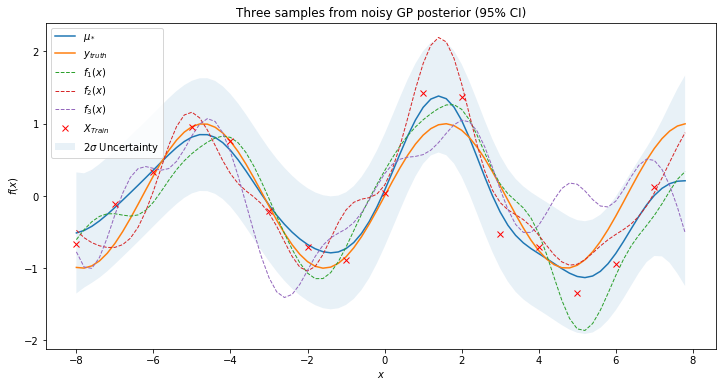

In [8]:
# Switch for random values
RV=False

# Number of training observations
N = 20

# Number of random functions (samples) drawn from the posterior
NF = 3

# Noise Training Observations
noise = 0.5

# Noisy training data either random or static
if RV==False:
    X_train = np.arange(np.min(X), np.max(X), 1).reshape(-1, 1)
    #X_train = np.linspace(np.min(X),np.max(X),N).reshape(-1, 1)
else:
    X_train = np.random.uniform(np.min(X),np.max(X),N).reshape(-1, 1)

# Target values with noise
Y_train = g(X_train,noise_variance=noise)

# Test/Function target values without noise 
y = g(X,noise_variance=0) 

# Compute mean and covariance of the posterior predictive distribution with additive noise
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, 
                                   sigma_y=noise, 
                                   use_cholesky=True,
                                   Kf=rbf_kernel)

# Draw random sample from the multivariate normal
f_noisy_posterior = np.random.multivariate_normal(mu_s.ravel(), cov_s, NF)

# Plot 1D GP
plt.figure(figsize=(12, 6))
plot_1D_gp(mu_s, cov_s, 
           X_test=X,y_test=y, 
           X_train=X_train, Y_train=Y_train, 
           f=f_noisy_posterior,title='Three samples from noisy GP posterior (95% CI)')

## Effect of kernel parameters and noise parameter 

The predictive performance of GPs depends exclusively on the suitability of the chosen kernel. In our case we are using the `RBF` kernel exclusively.

In the following example we want to adapt the different hyperparameters of our RBF kernel form equation $(16)$, respectively $l$ and $\sigma_f$ as well as the noise parameter $\sigma_y$ and investigate which impact the changes have for the GP posterior distribution. Therefore we are creating 20 noisy training observations with different parameter values and investigate how the change in the hyperparameters effect the predictive posterior distribution.

The first three choosen parameter triples values are the same as mentioned in chapter 15.2.3 in [1] that we can compare our results with the results from the book. The next three parameters triples are self-made only for investigating the behaviour.

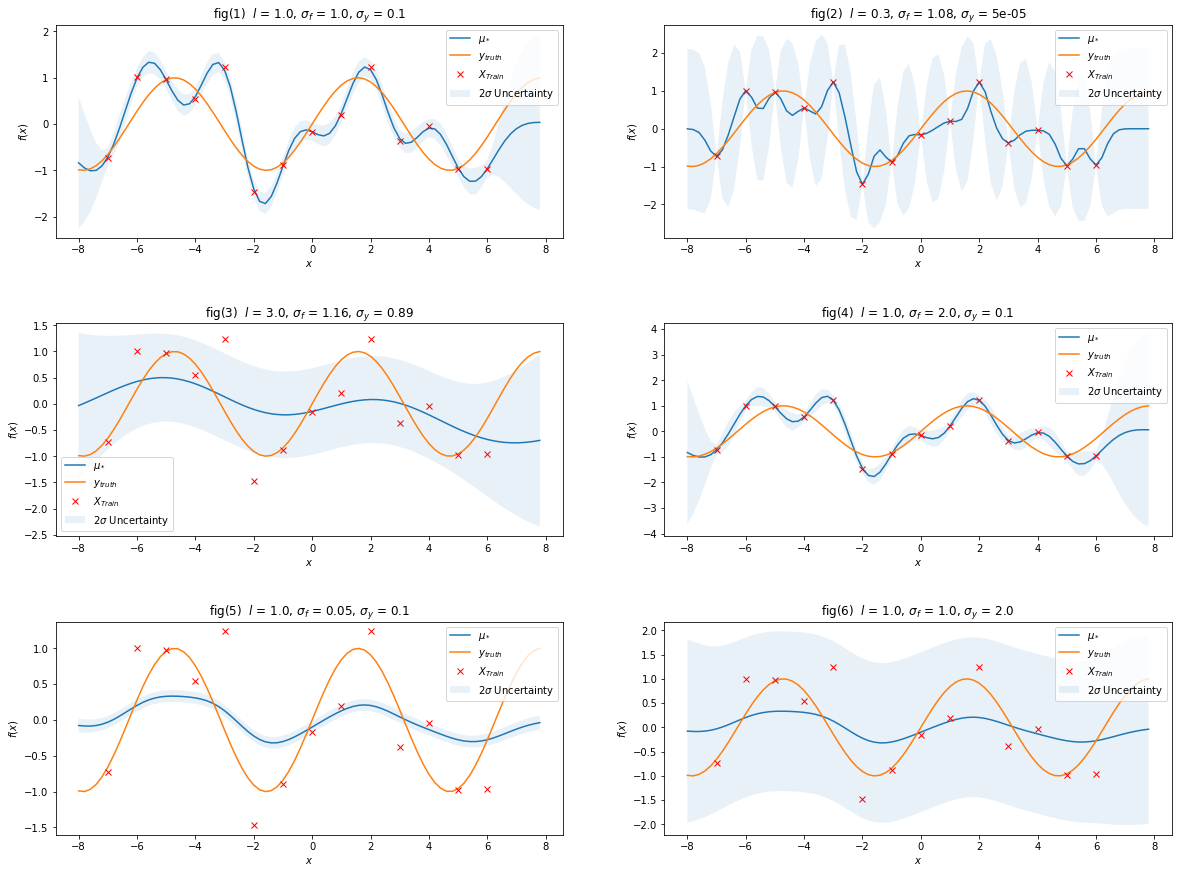

In [9]:
# Switch for random values
RV=False

# Number of training observations
N = 20

# Noisy training data either random or static
if RV==False:
    # -1/+1 to show the end of the scaling
    X_train = np.arange(np.min(X)+1, np.max(X)-1, 1).reshape(-1, 1)
    #X_train = np.linspace(np.min(X),np.max(X),N).reshape(-1, 1)
else:
    X_train = np.random.uniform(np.min(X),np.max(X),N).reshape(-1, 1)

# Target values with noise
Y_train = g(X_train,noise_variance=noise)    

# Test/Function target values without noise 
y = g(X,noise_variance=0) 

# l, sigma_f, sigma_y
hyperparams = [
    (1.0, 1.0, 0.1),
    (0.3, 1.08, 0.00005),
    (3.0, 1.16, 0.89),
    (1.0, 2.0, 0.1),
    (1.0, 0.05, 0.1),
    (1.0, 1.0,2.0),
]

plt.figure(figsize=(20, 6))

for i, (l, sigma_f, sigma_y) in enumerate(hyperparams):
        
    # Compute mean and covariance of the posterior predictive distribution with additive noise
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, 
                                       sigma_y=sigma_y, 
                                       use_cholesky=True,
                                       Kf=rbf_kernel,
                                       l=l,
                                       sigma_f=sigma_f)    
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.subplots_adjust(hspace=0.4)
    # Plot 1D GP
    plot_1D_gp(mu_s, cov_s, 
               X_test=X, y_test=y, 
               X_train=X_train, Y_train=Y_train,
               title=f'fig({i+1})  $l$ = {l}, $\sigma_f$ = {sigma_f}, $\sigma_y$ = {sigma_y}')
    

In the figures above we see how the GP posterior changes with change in the hyperparameters. We see a pretty good fit of the data in figure figure(1). We also see in the other two figures that higher $l$ values lead to smoother functions figure(3) and therefore to coarser approximations of the training data where as lower $l$ values make functions more "wiggly" with wide confidence intervals between training data points figure(2).

Small value of $\sigma_f$ characterize functions that stay close to their mean value figure(5), larger values allow more variation figure(4) and lead to wide confidence intervals outside the training data. If the signal variance is too large, the modelled function will be free to chase outliers.


As we know $\sigma_y^2$ is formally not a part of the covariance function itself. It is used by the Gaussian process model to allow for noise present in training data. It can be seen as an assumption parameter of how much noise is expected to be present in the data. Higher $\sigma_y$ values make more coarse approximations which avoids overfitting to noisy data figure(6).


## Estimating the kernel parameters

To estimate the optimal values for the kernel parameter we consider an empirical Bayes approach, which will allow us estimate this values by maximizing the marginal log-likelihood.

$$
\log p(\mathbf{y} \lvert \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0},\mathbf{K}_y) =
-\underbrace{\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y}}_{\substack{data-fit-term}} 
-\underbrace{\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix}}_{\substack{complexity-term}} 
-\underbrace{\frac{N}{2} \log(2\pi)}_{\substack{constant}}\tag{19}
$$


To understand the tradeoff between the data and complexity term, let us consider a squared exponential kernel in 1 dimension.

Holding the amplitude parameter $\sigma_y$ fixed, lets vary the length parameter $l$. For short length scales, the covariance is very wiggly (as we saw in the examples above), and thus 1 only near the diagonal. On the other hand, for large length scales, reasonably separated points are not different, and the covariance is close to 1 throughout.

Thus, for shorter length scales, the model complexity term is large. The fit will be very good. For longer length scales, the model complexity term will be small, as the matrix will be all ones, which results in a poor fit.

This corresponds to our general understanding of `bias` and `variance`: a long length scale imposes a very unwiggly, line like model, which will **underfit**, where as a model with a short length scale will have many wiggles, and thus possibly **overfit**.

* The `bias` is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).
* The `variance` is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting).


In [10]:
from numpy.linalg import cholesky
from scipy.optimize import minimize

def neg_log_likelihood(X_train, Y_train, noise=None, use_cholesky=True):
    '''
    Computes the negative log-likelihood for training data X_train and Y_train 
    and a optional noise level.
    
    Args:
        X_train: training locations (m x d)
        Y_train: training targets (m x 1)
        noise: known noise level will be added to the diagonal
        use_cholesky: use cholesky decomposition
        
    Returns:
        Negative Log Likelihood
    '''
    
    # Generate an innerfunction to update theta
    def update(theta):
        if noise is None:
            # Get the covariance K_y by using our kernel function and adding estimated additive noise value
            K_y = Kernel(rbf_kernel,X_train, X_train,l=theta[0], sigma_f=theta[1]) + \
                  theta[2]**2 * np.eye(len(X_train))
        else:
            # Get the covariance K_y by using our kernel function and adding known additive noise value
            K_y = Kernel(rbf_kernel,X_train, X_train,l=theta[0], sigma_f=theta[1]) + \
                  noise**2 * np.eye(len(X_train))
        
        # use cholesky or not
        if use_cholesky == False:
            data_fit_term = 0.5 * Y_train.T.dot(inv(K_y).dot(Y_train))
            complexity_term = 0.5 * np.log(np.linalg.det(K_y))
            constant_term = 0.5 * len(X_train) * np.log(2*np.pi)
        else:
            # Compute determinant via Cholesky decomposition (see Algorithm 15.1 in [1])
            L = cholesky(K_y)
            alpha = np.linalg.solve(L.T,np.linalg.solve(L,Y_train))
            data_fit_term = 0.5 * Y_train.T.dot(alpha)
            complexity_term = np.sum(np.log(np.diagonal(L))) 
            constant_term = 0.5 * len(X_train) * np.log(2*np.pi)
            
        return data_fit_term+complexity_term+constant_term
        
    return update


In the following example we will minimize the negative marginal log-likelihood to estimate optimal parameters $l$ and $\sigma_f$.  We will show how the posterior predictive change after the we optimize the values by plotting the original and optimized posterior predictive in 1D and 2D.

To estimate the optimal values we will use the `fit` function implemented below.
The noise value $\sigma_y$ can either be set to a known noise value $noise \geq 0$ or if the noise is unknown the parameter can be set to $noise=None$. In the second case $\sigma_y$ will be estimated along with the other parameters. 


In the next section [Validation of results](#Validation of results) the obtained optimizes hyperparametes will be validated agains a common library.

In [11]:
def fit(X_train,Y_train,init_hp=None,noise=None,n_restarts=100,use_cholesky=True,verbose=False):

    '''
    Returns optimized hyperparameters for the training data X_train and Y_train
    based on
    
    Args:
        X_train: training locations (m x d)
        Y_train: training targets (m x 1)
        init_hp: user defined hyperparameter values for initial guesses
        noise: known noise level will be added to the diagonal
        use_cholesky: use cholesky decomposition
        verbose: True or False for prit
        
    Returns:
        Return optimal hyperparmeters
    '''

    # Create random hyperparameter init values
    l_init, sigma_f_init = np.random.uniform(0.1,2.0,2)
    
    if noise is None:
        sigma_y_init = np.random.uniform(0.2,1)
    else:
        sigma_y_init = noise
    
    # 
    if init_hp is None:
        l_opt, sigma_f_opt,sigma_y_opt = init_hp = [l_init,sigma_f_init,sigma_y_init]
    else:
        l_opt, sigma_f_opt,sigma_y_opt = init_hp
        
   
    # Set inital best function fit 
    best_function = 1e6

    for i in range(n_restarts):  

        # use different initializations to avoid local minima
        log_hyp=np.log10(init_hp)
        init_hyp_guess=log_hyp+(log_hyp-initial_hyperparams)*np.random.random(size=log_hyp.shape)
        init_hyp_guess=10.0**init_hyp_guess   
        
        # If noise is known set init_hyp_guess respectively
        if noise is not None:
            init_hyp_guess[2] = noise
        
        res = minimize(neg_log_likelihood(X_train,Y_train,noise=noise,use_cholesky=use_cholesky), init_hyp_guess, 
                           bounds=((1e-5, 4), (1e-5, 4),(1e-5, 3)),
                           method='L-BFGS-B')
                           #tol=1e-12,
                           #options={'disp':True,'eps':0.0001})
        
        
        # first check if there is a better function
        if res.fun <= best_function:
            l_opt, sigma_f_opt,sigma_y_opt = res.x
            best_function = res.fun
            if verbose == True:
                print(f' Searching iter:{i+1} l = {l_opt}, sigma_f = {sigma_f_opt}, sigma_y = {sigma_y_opt} ')      
                
        elif np.allclose([l_opt, sigma_f_opt,sigma_y_opt],res.x,atol=1e-05) and not res.fun < best_function:
            # seems like we found optimal values
            if verbose == True:
                print(f' Optimal iter:{i+1} l = {l_opt}, sigma_f = {sigma_f_opt}, sigma_y = {sigma_y_opt} ')
                print(res)
            break
        else:
            pass
                      
    return l_opt, sigma_f_opt,sigma_y_opt

## 1D representation of the data

Now we will generate some noisy data for estimating the optimal hyperparameters. These values are used for the next sections to evaluate the data in higher dimensions as well as validate the data against the computation of `Scikit-learn` library.

In [12]:
# Switch for random values
RV=False

# Number of training observations
N = 10

# Max number of iterations to find optimal hyperparameters
N_iter = 200

# Definition of the intital hyperparameters
l_init, sigma_f_init, sigma_y_init = initial_hyperparams=[1.0, 1.0, 0.1] 

# Noisy training data either random or static
if RV==False:
    # -1/+1 to show the end of the scaling
    X_train = np.arange(np.min(X)+1, np.max(X)-1, 1).reshape(-1, 1)
    #X_train = np.linspace(np.min(X),np.max(X),N).reshape(-1, 1)
else:
    X_train = np.random.uniform(np.min(X),np.max(X),N).reshape(-1, 1)

# Target values without noise
Y_train = g(X_train,noise_variance=sigma_y_init)

# Test/Function target values without noise 
y = g(X,noise_variance=0)     


 Searching iter:1 l = 0.13706132099531212, sigma_f = 0.6734301051233436, sigma_y = 1.0609450924809568e-05 
 Searching iter:2 l = 0.1449436831057242, sigma_f = 0.6734300521479933, sigma_y = 1.0036532633526931e-05 
 Searching iter:3 l = 1.8626258508701679, sigma_f = 1.0432797395133409, sigma_y = 0.11806338627506302 
 Searching iter:5 l = 1.862627438662632, sigma_f = 1.0432794450487035, sigma_y = 0.11806352861612159 
 Optimal iter:6 l = 1.862627438662632, sigma_f = 1.0432794450487035, sigma_y = 0.11806352861612159 
      fun: array([[8.10239763]])
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.93622895e-05,  3.90798505e-05, -2.89368529e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 200
      nit: 18
   status: 0
  success: True
        x: array([1.86264009, 1.04329257, 0.11806279])
                                     Initial guess                Optimized
                        l                      1.0        1.862627438662

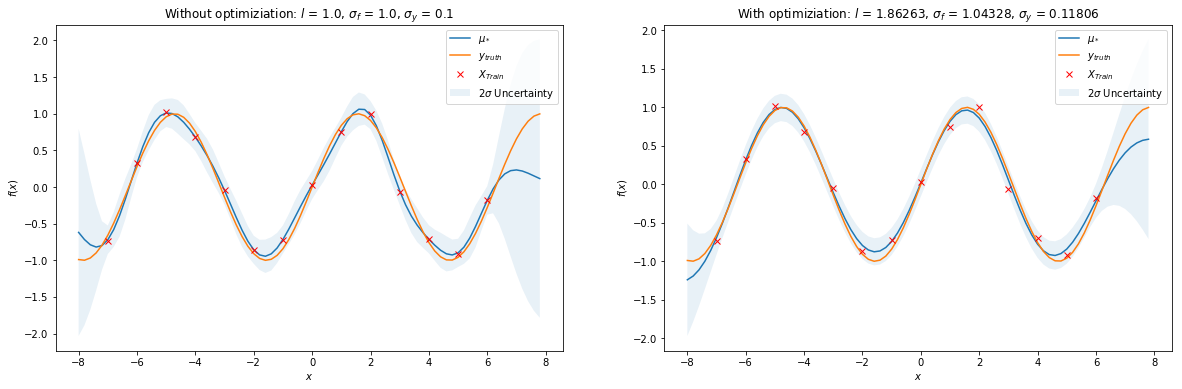

In [13]:
# Compute the prosterior predictive without optimized kernel parameters
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, 
                                   sigma_y=sigma_y_init, 
                                   use_cholesky=True,
                                   Kf=rbf_kernel,
                                   l=l_init,
                                   sigma_f=sigma_f_init) 

# Calculate optimal hyperparameter values
l_opt, sigma_f_opt,sigma_y_opt = fit(X_train=X_train,Y_train=Y_train,
                                     init_hp=initial_hyperparams,
                                     #noise=sigma_y_init, # known noise (uncomment for sigma_y estimation)
                                     n_restarts=N_iter,
                                     use_cholesky=True,
                                     verbose=True)


# Compute the prosterior predictive with optimized kernel parameters
mu_s_opt, cov_s_opt = posterior_predictive(X, X_train, Y_train, 
                                           sigma_y=sigma_y_opt, 
                                           use_cholesky=True,
                                           Kf=rbf_kernel,
                                           l=l_opt,
                                           sigma_f=sigma_f_opt) 


plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
#plt.subplots_adjust(top=2)
plt.subplots_adjust(hspace=0.4)

# Plot 1D GP
plot_1D_gp(mu_s, cov_s, 
           X_test=X, y_test=y, 
           X_train=X_train, Y_train=Y_train,
           title=f'Without optimiziation: $l$ = {l_init}, $\sigma_f$ = {sigma_f_init}, $\sigma_y$ = {sigma_y_init}')

plt.subplot(1, 2, 2)    
# Plot 1D GP optimized
plot_1D_gp(mu_s_opt, cov_s_opt, 
           X_test=X, y_test=y, 
           X_train=X_train, 
           Y_train=Y_train,
           title=f'With optimiziation: $l$ = {l_opt:.5f}, $\sigma_f$ = {sigma_f_opt:.5f}, $\sigma_y$ = {sigma_y_opt:.5f}')



# Print the optimizes values in relation to the init values
headingList = ["Initial guess", "Optimized"]
hyperList = ['l','sigma_f','sigma_y']
data = np.array([[l_init, l_opt],
                 [sigma_f_init, sigma_f_opt],
                 [sigma_y_init, sigma_y_opt]])

row_format ="{:>25}" * (len(headingList) + 1)
print (row_format.format("", *headingList))
for team, row in zip(hyperList, data):
      print (row_format.format(team, *row))



## 2D representation of the data

We are also be able to represent the data in higher dimensions using the same setup as above. If we compare our plots with the truth, we will see, that our sinusoidal function $g(x)$ is approximated much better after parameter optimization. Try to change the function and see what happens with the plot.

 Searching iter:1 l = 1.9229411430399772, sigma_f = 0.8577722359489254, sigma_y = 0.10860524811412117 
 Searching iter:2 l = 1.922939850990108, sigma_f = 0.8577709993238405, sigma_y = 0.10860519953561469 
 Optimal iter:3 l = 1.922939850990108, sigma_f = 0.8577709993238405, sigma_y = 0.10860519953561469 
      fun: -17.307313459854157
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([2.84217094e-05, 1.42108547e-05, 3.69482223e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 112
      nit: 17
   status: 0
  success: True
        x: array([1.92294081, 0.85777228, 0.10860522])


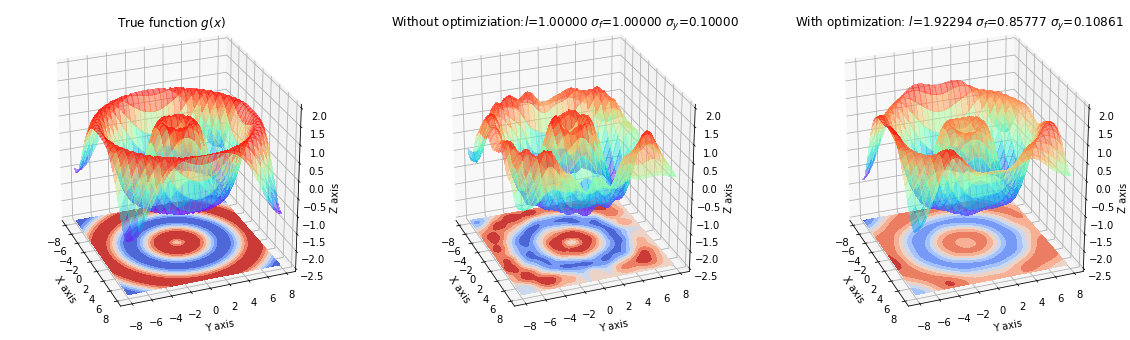

In [14]:
# Generate meshgrid based on testvalues
gx, gy = np.meshgrid(X, X)

# Create Stacked columnwise array 
# np.c_[gx.ravel(), gy.ravel()]  or np.dstack((gx.ravel(), gy.ravel())).reshape(-1,2) also working
X_2D = np.column_stack((gx.ravel(), gy.ravel()))

if RV==False:
    # -1/+1 to show the end of the scaling
    #X_train_arange = np.arange(np.min(X)+1, np.max(X)-1, 1).reshape(-1, 1)
    X_train_2D = np.dstack(np.meshgrid(X_train, X_train)).reshape(-1, 2)
else:
    X_train_2D = np.random.uniform(min(X), max(X), (N*N//2, 2))
    
# Create noisy training data
Y_train_2D = g(np.linalg.norm(X_train_2D, axis=1),noise_variance=sigma_y_init)

# Test/Function target values without noise 
y_2D = g(np.linalg.norm(X_2D, axis=1),noise_variance=0)     


plt.figure(figsize=(20, 6))

# Plot 2D truth
plot_2D_gp(gx, gy,y_2D,None,None,f'True function $g(x)$', 1)


# Compute the prosterior predictive without optimized kernel parameters
mu_s_2D, cov_s = posterior_predictive(X_2D, X_train_2D, Y_train_2D, 
                                       sigma_y=sigma_y_init, 
                                       use_cholesky=True,
                                       Kf=rbf_kernel,
                                       l=l_init,
                                       sigma_f=sigma_f_init) 

# Plot 2D without optimized hyperparameters
plot_2D_gp(gx, gy, mu_s_2D,None,None,
           f'Without optimiziation:$l$={l_init:.5f} $\sigma_f$={sigma_f_init:.5f} $\sigma_y$={sigma_y_init:.5f}', 2)


# Calculate optimal hyperparameter values
l_opt_2D, sigma_f_opt_2D,sigma_y_opt_2D = fit(X_train=X_train_2D,Y_train=Y_train_2D,
                                         init_hp=initial_hyperparams,
                                         #noise=sigma_y_init, # known noise (uncomment for sigma_y estimation)
                                         n_restarts=N_iter,
                                         use_cholesky=True,
                                         verbose=True)
    

# Compute the prosterior predictive with optimized kernel parameters
mu_s_opt_2D, cov_s_opt_2D = posterior_predictive(X_2D, X_train_2D, Y_train_2D, 
                                   sigma_y=sigma_y_opt_2D, 
                                   use_cholesky=True,
                                   Kf=rbf_kernel,
                                   l=l_opt_2D,
                                   sigma_f=sigma_f_opt_2D) 


# Plot 2D with optimized hyperparameters
plot_2D_gp(gx, gy, mu_s_opt_2D,None,None,
           f'With optimization: $l$={l_opt_2D:.5f} $\sigma_f$={sigma_f_opt_2D:.5f} $\sigma_y$={sigma_y_opt_2D:.5f}', 3)


## Validation of results
<a id='Validation of results'></a>
### Scikit-learn

To validate the results of our optimized hyperparameters $l$, $\sigma_f$ and $\sigma_y$ we will use the `GaussianProcessRegressor` implemented in the scikit-learn library. Information and examples about the `GaussianProcessRegressor` can be found in the scikit-learn documentation [Gaussian Process Regression (GPR)](http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-regression-gpr). There are several predefined kernels available that can be used for generating the GP [Kernels for Gaussian Processes](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes). To compare our results we are using the [`RBF Kernel`](https://scikit-learn.org/stable/modules/gaussian_process.html#radial-basis-function-rbf-kernel) from the library.

Unfortunately the `RBF Kernel` has only a `length_scale` hyperparameter, which is equal to our $l$ hyperparameter.
Because we want to estimate $\sigma_f$ as well we need to compose the `RBF` with a `ConstantKernel` (Example can be found here [Gaussian Proccess Regression (Example)](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html)


In [15]:
def print_validation(title, a, b, a_str='GaussianNumpy', b_str='GaussianRegressor'):
    print(title)
    print('-' * len(title))
    print(f'{a_str}: {a}')
    print(f'{b_str}: {b}')
    print(f'Ratio:'+' ' * (len(a_str)-len('Ratio')), np.divide(a,b))
    print("")

Validate l
----------
GaussianNumpy: 1.862627438662632
GaussianRegressor: 1.8626277751487992
Ratio:         0.9999998193486795

Validate sigma_f
----------------
GaussianNumpy: 1.0432794450487035
GaussianRegressor: 1.0432798881388856
Ratio:         0.9999995752911686

Validate mu_s
-------------
GaussianNumpy: -0.02997445763342498
GaussianRegressor: -0.02997444888022761
Ratio:         1.000000292021962

Validate cov_s
--------------
GaussianNumpy: 0.002622560983995637
GaussianRegressor: 0.0026225613014859124
Ratio:         0.9999998789388544



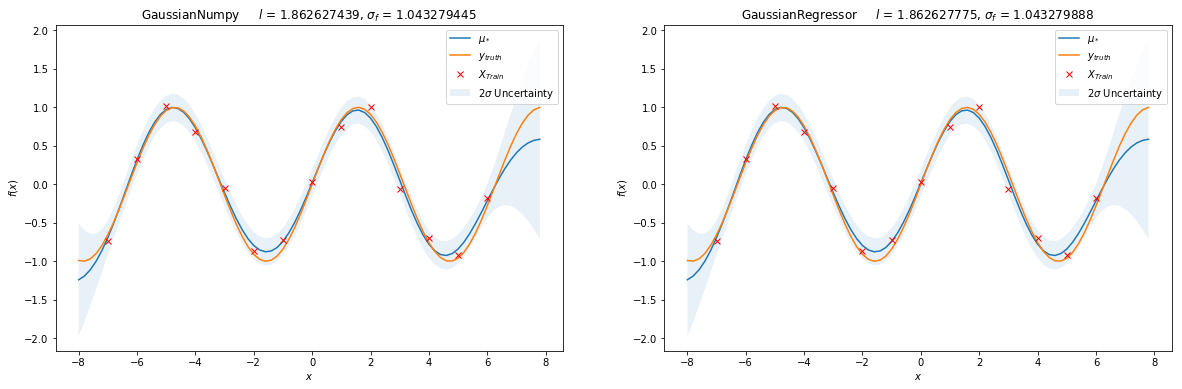

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = C(sigma_f_init) * RBF(length_scale=l_init)

# Use same noise as above. If we predict the noise we should put it into as alpha value, 
gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma_y_opt**2,n_restarts_optimizer=N_iter)


# Traing Data from Cells above
gpr.fit(X_train, Y_train)

# Predict posterior predictive mean and covariance
mu_s_val, cov_s_val = gpr.predict(X, return_cov=True)

# Obtain optimized kernel parameters (Don't know if there is another way to get the hyperparameters)
l_val= gpr.kernel_.k2.get_params()['length_scale']
sigma_f_val = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

print_validation('Validate l',l_opt,l_val)
print_validation('Validate sigma_f',sigma_f_opt,sigma_f_val)
print_validation('Validate mu_s',np.mean(mu_s_opt.ravel()), np.mean(mu_s_val.ravel()))
print_validation('Validate cov_s',np.mean(cov_s_opt.ravel()), np.mean(cov_s_val.ravel()))

# Compare our results with the GaussianRegressor
assert(np.isclose(l_opt, l_val))
assert(np.isclose(sigma_f_opt, sigma_f_val))
assert(np.isclose(np.mean(mu_s_opt.ravel()), np.mean(mu_s_val.ravel())))
assert(np.isclose(np.mean(cov_s_opt.ravel()), np.mean(cov_s_val.ravel())))


# Plot the results
plt.figure(figsize=(20, 6))

plt.subplots_adjust(hspace=0.4)
plt.subplot(1, 2, 1)

# Plot 1D GaussianNumpy
plot_1D_gp(mu_s_opt, cov_s_opt, 
           X_test=X, y_test=y, 
           X_train=X_train, 
           Y_train=Y_train,
           title=f'GaussianNumpy     $l$ = {l_opt:.9f}, $\sigma_f$ = {sigma_f_opt:.9f}')

# Plot 1D GaussianRegressor
plt.subplot(1, 2, 2)
plot_1D_gp(mu_s_val, cov_s_val, 
           X_test=X, y_test=y, 
           X_train=X_train, 
           Y_train=Y_train,
           title=f'GaussianRegressor     $l$ = {l_val:.9f}, $\sigma_f$ = {sigma_f_val:.9f}')



## Interactive Hyperparameter Playground

The following `Inteactive Hyperparameter Playground` shall give you an more intuitive insight into the GP and the hyperparameters (here for RBF Kernel).


In [17]:
def InteractiveHyperparameterPlayground():
    # To prevent automatic figure display when execution of the cell ends
    #%config InlineBackend.close_figures=False 
    import ipywidgets as widgets
    from ipywidgets import Layout,interact, interactive, fixed, interact_manual, interactive_output
    from IPython.display import display, clear_output
    from matplotlib import pyplot as plt
    from ipywidgets.widgets.interaction import show_inline_matplotlib_plots


    ''' Create Interactive application'''

    # turn intactive mode off
    plt.ioff()
    plt.close('all')
    # create output window
    #out=widgets.Output(layout=Layout(height='100%', width = '100%', border='solid'))
    out = widgets.Output()

    # Button for generating random data
    btn_genData=widgets.Button(description=' Gen Train Data')

    # Number of trainin Data
    num_data_slider = widgets.IntSlider(
                                        value=10,
                                        min=1,
                                        max=20,
                                        step=1,
                                        description='$N_{RandTrain}$',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d'
                                          )
    num_samples_slider = widgets.IntSlider(
                                            value=0,
                                            min=0,
                                            max=10,
                                            step=1,
                                            description='$N_{Post.Sample}$',
                                            disabled=False,
                                            continuous_update=False,
                                            orientation='horizontal',
                                            readout=True,
                                            readout_format='d'
                                            )
    # we need three sliders for the hyperparameters
    l_slider = widgets.FloatSlider( 
                                        value=1.0,
                                        min=0.1,
                                        max=5.0,
                                        step=0.1,
                                        description='$l$',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='.1f',
                                    )

    sigma_f_slider = widgets.FloatSlider( 
                                            value=1.0,
                                            min=0.1,
                                            max=5.0,
                                            step=0.1,
                                            description='$\sigma_f$',
                                            disabled=False,
                                            continuous_update=False,
                                            orientation='horizontal',
                                            readout=True,
                                            readout_format='.1f',
                                        )
    sigma_y_slider = widgets.FloatSlider( 
                                            value=0.0,
                                            min=0.0,
                                            max=3.0,
                                            step=0.05,
                                            description='$\sigma_y$',
                                            disabled=False,
                                            continuous_update=False,
                                            orientation='horizontal',
                                            readout=True,
                                            readout_format='.2f',
                                        )


    ''' Initial Variables'''

    # Finite number of test points
    X = np.arange(-8, 8, 0.2).reshape(-1, 1)

    # Test/Function target values without noise 
    y = g(X,noise_variance=0) 

    # Random number of training points
    X_train = np.random.uniform(np.min(X),np.max(X),num_data_slider.value).reshape(-1, 1)

    # Same additve noise for Training observations
    Y_train = g(X_train,noise_variance=sigma_y_slider.value)




    #interact(l=l_slider,sigma_f=sigma_f_slider,sigma_y=sigma_y_slider,num_samples=num_samples)
    def interactive_posterior_predictive(l,sigma_f,sigma_y,num_samples):    

        with out:
            clear_output(wait=True)
            fig=plt.figure(figsize=(20, 10))
            mu_s, cov_s = posterior_predictive(X, X_train, Y_train, 
                                       sigma_y=sigma_y, 
                                       use_cholesky=True,
                                       Kf=rbf_kernel,
                                       l=l,
                                       sigma_f=sigma_f) 

            # Draw random sample from the multivariate normal
            f_posterior = np.random.multivariate_normal(mu_s.ravel(), cov_s, num_samples)

            plot_1D_gp(mu_s, cov_s, 
                       X_test=X, y_test=y,
                       X_train=X_train, 
                       Y_train=Y_train,
                       f=f_posterior,
                       title=f'$l$ = {l}, $\sigma_f$ = {sigma_f}, $\sigma_y$ = {sigma_y}')
            plt.show()

    #@interact(N=num_data)
    def interactive_train_data(N,N_noise):
        global X_train
        global Y_train

        #X_train = np.random.uniform(np.min(X),np.max(X),N)
        X_train = np.linspace(np.min(X)+1,np.max(X)-1, N, endpoint=True).reshape(-1, 1)
        Y_train = g(X_train,noise_variance=N_noise)

        with out:
            interactive_posterior_predictive(l_slider.value,sigma_f_slider.value,N_noise,num_samples_slider.value)

    # Create the layout
    display(widgets.HTML(value="<h3><center>Interactive Hyperparameter Playground</center></h3>",))
    uiNums= widgets.HBox([sigma_y_slider,num_data_slider],
                        layout=Layout(height='100%', width = '100%', border='solid'))
    uiHypParams= widgets.HBox([l_slider, sigma_f_slider,num_samples_slider],
                              layout=Layout(height='100%', width = '100%', border='solid'))

    interactive_output (interactive_train_data,{'N':num_data_slider,
                                                'N_noise':sigma_y_slider})
    interactive_output(interactive_posterior_predictive,{'l':l_slider, 
                                                         'sigma_f':sigma_f_slider, 
                                                         'sigma_y':sigma_y_slider, 
                                                         'num_samples':num_samples_slider})

    display(uiNums,out,uiHypParams)

# Start interactive Hyperparameter Playground
InteractiveHyperparameterPlayground()

HTML(value='<h3><center>Interactive Hyperparameter Playground</center></h3>')

Output()

## References

[1] Kevin P. Murphy. [Machine Learning, A Probabilistic Perspective](https://doc.lagout.org/science/Artificial%20Intelligence/Machine%20learning/Machine%20Learning_%20A%20Probabilistic%20Perspective%20%5BMurphy%202012-08-24%5D.pdf), Chapters 4, 14 and 15.  
[2] Christopher M. Bishop. [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf), Chapter 6.  
[3] Carl Edward Rasmussen and Christopher K. I. Williams. [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/).  